                                                                                    Бердникович Алеся, 4- сложная

# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

35.193714518227559

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.999730005094072

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [69]:
x=np.random.exponential(2,size =sample_size)
noize= np.random.uniform(size = sample_size, low = -1, high = 1)
y=f(x)+noize

In [36]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier


In [71]:
X=x.reshape(-1,1,)
Y=y.reshape(-1,1,)
reg=DecisionTreeRegressor().fit(X,Y)

In [72]:
y_pred=reg.predict(linspace.reshape(-1,1,))

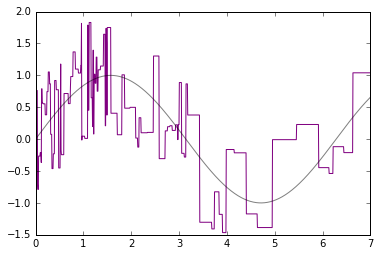

In [73]:
plt.plot(linspace, y_pred,color='purple',alpha = 1)
plt.plot(linspace, f(linspace),color='black',alpha = 0.5)
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

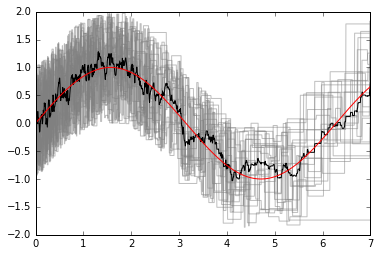

In [74]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=DecisionTreeRegressor().fit(X,Y)
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

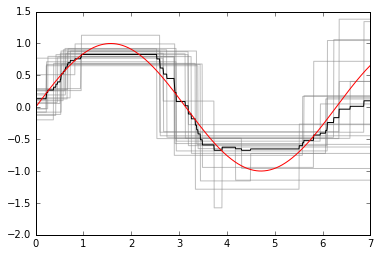

In [75]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=DecisionTreeRegressor(max_depth=2).fit(X,Y)
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

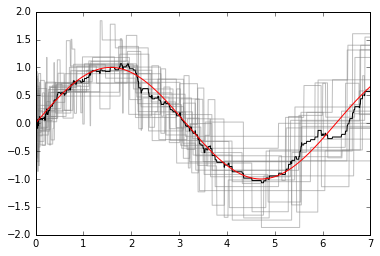

In [76]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=DecisionTreeRegressor(max_depth=4).fit(X,Y)
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

     Чем меньше допустимая глубина дерева, тем больше смещение. В нашем случае наибольшее смещение при max_depth=2, так как если максимальная глубина не ограничена, как в 1 случае, то она может быть очень большой (в случае если не накладывается других ограничений, как минимальное количество объектов в листе и др).



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [37]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

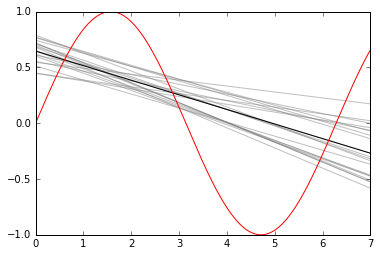

In [80]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=LinearRegression().fit(X,Y)
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

/Users/Air11/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


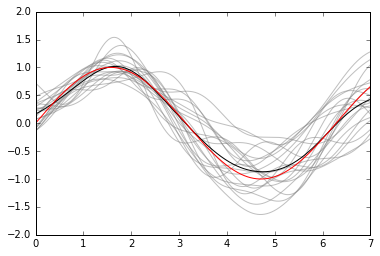

In [77]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=SVR(kernel='rbf', gamma = 1).fit(X,Y)
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

/Users/Air11/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


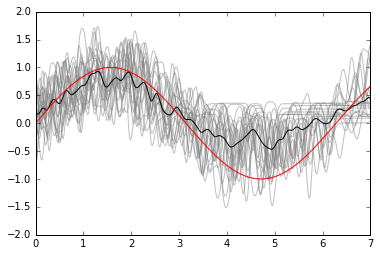

In [78]:
a=[]
for i in range (samples_num):
    x=np.random.exponential(scale=2,size =sample_size)
    noize= np.random.uniform(size = sample_size, low = -1, high = 1)
    y=f(x)+noize
    X=x.reshape(-1,1,)
    Y=y.reshape(-1,1,)
    reg=SVR(kernel='rbf', gamma = 100).fit(X,Y)
    
    y_pred=reg.predict(linspace.reshape(-1,1,))
    a.append(y_pred)
    plt.plot(linspace, y_pred,color='gray',alpha = 0.5)
    
plt.plot(linspace,np.mean(a,axis=0),color='black',alpha = 1)    
plt.plot(linspace, f(linspace),color='red',alpha = 1)
plt.show()

    Самое маленькое смещение при SVR с параметром гамма=1,при этом и разброс тоже не такой большой в этой модели.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [7]:
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [122]:
#mushrooms 
d1 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)
y1 = preprocessing.LabelEncoder().fit_transform(d1[0])
x1 = d1.loc[:,1:]
#tic-rac-toe 
d2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header=None)
y2 = preprocessing.LabelEncoder().fit_transform(d2[9])
x2 = d2.loc[:,:8]
#cars 
d3 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
d3[6][d3[6].isin(['unacc', 'acc'])] = 0
d3[6][d3[6].isin(['vgood', 'good'])] = 1
y3 =preprocessing.LabelEncoder().fit_transform(d3[6])
x3 = d3.loc[:,:5]
#nursery
d4 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
d4[8][d4[8].isin(['not_recom', 'recommend'])] = 0
d4[8][d4[8].isin(['very_recom', 'priority', 'spec_prior'])] = 1
y4 = preprocessing.LabelEncoder().fit_transform(d4[8])
x4 = d4.loc[:,:7]

 ##### 1)mushrooms 

    1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
    2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
    3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
    4. bruises?: bruises=t,no=f 
    5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
    6. gill-attachment: attached=a,descending=d,free=f,notched=n 
    7. gill-spacing: close=c,crowded=w,distant=d 
    8. gill-size: broad=b,narrow=n 
    9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
    10. stalk-shape: enlarging=e,tapering=t 
    11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
    14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
    15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
    16. veil-type: partial=p,universal=u 
    17. veil-color: brown=n,orange=o,white=w,yellow=y 
    18. ring-number: none=n,one=o,two=t 
    19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
    20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
    21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
    22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

Тут все признаки категориальные, сделаем сначала просто дамми переменные для всех признаков (корректное разбиение).

In [8]:
x1_cat=pd.get_dummies(x1)

In [111]:
print('Если все категориальные, то точность:',np.mean(cross_val_score(X=x1_cat, y=y1, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все категориальные, то точность: 0.967279246159


In [10]:
x1_num=pd.DataFrame()
for i in x1.columns:
    x1_num =pd.concat([x1_num, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(x1[i]))], axis = 1)

In [112]:
print('Если все вещественные, то точность:',np.mean(cross_val_score(X=x1_num, y=y1, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все вещественные, то точность: 0.962593066128


Логично, что точность снижается, когда мы пытаемся упорядочить равнозначные категории.

 ##### 2)tic-rac-toe 

    1. top-left-square: {x,o,b} 
    2. top-middle-square: {x,o,b} 
    3. top-right-square: {x,o,b} 
    4. middle-left-square: {x,o,b} 
    5. middle-middle-square: {x,o,b} 
    6. middle-right-square: {x,o,b} 
    7. bottom-left-square: {x,o,b} 
    8. bottom-middle-square: {x,o,b} 
    9. bottom-right-square: {x,o,b} 
    10. Class: {positive,negative}

Аналогично предыдущему пункту

In [113]:
x2_cat=pd.get_dummies(x2)
print('Если все категориальные, то точность:', np.mean(cross_val_score(X=x2_cat, y=y2, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все категориальные, то точность: 0.821540852776


In [114]:
x2_num=pd.DataFrame()
for i in x2.columns:
    x2_num =pd.concat([x2_num, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(x2[i]))], axis = 1)
print('Если все вещественные, то точность:',np.mean(cross_val_score(X=x2_num, y=y2, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все вещественные, то точность: 0.755295035269


Мы видим, что если вид признаков определен неверно, то точность снижается. 

 ##### 3)cars  

    buying: vhigh, high, med, low. 
    maint: vhigh, high, med, low. 
    doors: 2, 3, 4, 5more. 
    persons: 2, 4, more. 
    lug_boot: small, med, big. 
    safety: low, med, high. 

Вот в данном случае все категории должны быть упорядочены, то есть будет правильнее рассматривать их как вещественные, только надо правильно упорядочить (Это и будет правильное кодирование+ считаем что все вещественные(точнее порядковые))

In [14]:
x33=x3.copy()

In [39]:
x3.head()

,0,1,2,3,4,5
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [18]:
x33[0][x33[0].isin(['vhigh'])] = 3
x33[0][x33[0].isin(['high'])] = 2
x33[0][x33[0].isin(['med'])] = 1
x33[0][x33[0].isin(['low'])] = 0

x33[1][x33[1].isin(['vhigh'])] = 3
x33[1][x33[1].isin(['high'])] = 2
x33[1][x33[1].isin(['med'])] = 1
x33[1][x33[1].isin(['low'])] = 0


x33[2][x33[2].isin(['5more'])] = 5

x33[3][x33[3].isin(['more'])] = 5

x33[5][x33[5].isin(['high'])] =2
x33[5][x33[5].isin(['med'])] = 1
x33[5][x33[5].isin(['low'])] = 0

x33[4][x33[4].isin(['big'])] = 2
x33[4][x33[4].isin(['med'])] = 1
x33[4][x33[4].isin(['small'])] =0

In [130]:
print('Если кодирование правильное, то точность:', np.mean(cross_val_score(X=x33, y= y3, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если кодирование правильное, то точность: 0.875200481155


Теперь если будем считать, что все категориальные:

In [132]:
x3_cat=pd.get_dummies(x3)
print('Если все категориальные, то точность:', np.mean(cross_val_score(X=x3_cat, y=y3, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все категориальные, то точность: 0.822861534349


А если бы мы не упорядочили в ручную, а сделали просто LabelEncoder()

In [133]:
x3_num=pd.DataFrame()
for i in x3.columns:
    x3_num =pd.concat([x3_num, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(x3[i]))], axis = 1)
print('Если все вещественные и LabelEncoder(), то точность:',np.mean(cross_val_score(X=x3_num, y=y3, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все вещественные и LabelEncoder(), то точность: 0.94097166533


 Явно при задании всех признаков категориальными, точность сильно снижается, так как тут важно учитывать, что "low" это хуже, чем "high" и что это неравнозначные категории. При этом правильное ранжирование категорий почему-то уменьшает точность по сравнению с LabelEncoder()

 ##### 4)nursery 

    parents: usual, pretentious, great_pret 
    has_nurs: proper, less_proper, improper, critical, very_crit 
    form: complete, completed, incomplete, foster 
    children: 1, 2, 3, more 
    housing: convenient, less_conv, critical 
    finance: convenient, inconv 
    social: non-prob, slightly_prob, problematic 
    health: recommended, priority, not_recom

In [48]:
x4.head()

,0,1,2,3,4,5,6,7
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority


In [49]:
x44=x4.copy()

In [64]:
x44[0][x44[0].isin(['usual'])] = 0
x44[0][x44[0].isin(['pretentious'])] = 1
x44[0][x44[0].isin(['great_pret'])] = 2

x44[1][x44[1].isin(['proper'])] = 4
x44[1][x44[1].isin(['less_proper'])] = 3
x44[1][x44[1].isin(['improper'])] = 2
x44[1][x44[1].isin(['critical'])] = 1
x44[1][x44[1].isin(['very_crit'])] = 0

x44[2][x44[2].isin(['complete'])] = 3
x44[2][x44[2].isin(['completed'])] = 2
x44[2][x44[2].isin(['incomplete'])] = 1
x44[2][x44[2].isin(['foster'])] = 0


x44[3][x44[3].isin(['more'])] = 4

x44[5][x44[5].isin(['convenient'])] =1
x44[5][x44[5].isin(['inconv'])] = 0

x44[4][x44[4].isin(['convenient'])] = 2
x44[4][x44[4].isin(['less_conv'])] = 1
x44[4][x44[4].isin(['critical'])] =0

x44[6][x44[6].isin(['nonprob'])] = 2
x44[6][x44[6].isin(['slightly_prob'])] = 1
x44[6][x44[6].isin(['problematic'])] =0

x44[7][x44[7].isin(['recommended'])] = 2
x44[7][x44[7].isin(['priority'])] = 1
x44[7][x44[7].isin(['not_recom'])] =0

In [134]:
print('Если кодирование правильное, то точность:', np.mean(cross_val_score(X=x44, y= y4, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если кодирование правильное, то точность: 0.999691477008


In [137]:
x4_cat=pd.get_dummies(x4)
print('Если все категориальные, то точность:', np.mean(cross_val_score(X=x4_cat, y=y4, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все категориальные, то точность: 0.99953715602


In [136]:
x4_num=pd.DataFrame()
for i in x4.columns:
    x4_num =pd.concat([x4_num, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(x4[i]))], axis = 1)
print('Если все вещественные и LabelEncoder(), то точность:',np.mean(cross_val_score(X=x4_num, y=y4, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))

Если все вещественные и LabelEncoder(), то точность: 0.999691477008


При правильном ранжировании точность такая же, как при неправильном... Но категориальные по-прежнему хуже!

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

В первых двух датасетах лучше работает стратегия, когда мы учитываем все признаки, как категориальные (то есть с неранжируемыми категориями: например, нельзя сказать, что лучше "зеленый" или "красный"), поэтому при попытке их ранжировать мы теряем точность, так как это бессмысленно. Во вторых двух датасетах, наоборот, нужно это учитывать, поэтому точность использования LabelEncoder() выше.


При этом задавая кросс-валидационное разбиение, мы использовали просто cv=10, то есть единовременное случайное разделение выборки на непересекающиеся части, а потом делали для каждой предсказания. Хотя тут и присутствует случайная составляющая, может так получиться, что в обучение попадут "неподходящие" объекты, например, с одинаковыми значениями какого-нибудь важного признака. Если добавить случайности при разделении выборки и 10 раз случайно выбрать какое-то количество объектов (не делая группы непересекающимися), мы должны получить бОльшую точность. Попробуем использовать ShuffleSplit.

In [138]:
print('Если кодирование правильное, то точность:', np.mean(cross_val_score(X=x33, y= y3, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))
print('Если все категориальные, то точность:', np.mean(cross_val_score(X=x3_cat, y=y3, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))
print('Если все вещественные и LabelEncoder(), то точность:',np.mean(cross_val_score(X=x3_num, y=y3, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))

Если кодирование правильное, то точность: 0.991522157996
Если все категориальные, то точность: 0.985163776493
Если все вещественные и LabelEncoder(), то точность: 0.990558766859


In [139]:
print('Если кодирование правильное, то точность:', np.mean(cross_val_score(X=x44, y= y4, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))
print('Если все категориальные, то точность:', np.mean(cross_val_score(X=x4_cat, y=y4, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))
print('Если все вещественные и LabelEncoder(), то точность:',np.mean(cross_val_score(X=x4_num, y=y4, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits= 10, test_size=0.3, random_state=0), scoring=make_scorer(accuracy_score))))

Если кодирование правильное, то точность: 0.999845679012
Если все категориальные, то точность: 0.999794238683
Если все вещественные и LabelEncoder(), то точность: 0.999794238683


Точность, действительно, выше и ответы более логичные. Теперь правильное разбиение дает более точные результаты.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [140]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


In [8]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [142]:
y = data['quality']
X = data.drop(['quality'], 1)

In [146]:
print('Если используем DecisionTreeClassifier, то точность:', np.mean(cross_val_score(X=X, y=y, estimator=DecisionTreeClassifier(), cv=ShuffleSplit(n_splits=3, test_size=0.3, random_state=123), scoring=make_scorer(accuracy_score))))

Если используем DecisionTreeClassifier, то точность: 0.586111111111


In [147]:
print('Если используем BaggingClassifier со 100 деревьями, то точность:', np.mean(cross_val_score(X=X, y=y, estimator=BaggingClassifier(n_estimators = 100), cv=ShuffleSplit(n_splits=3, test_size=0.3, random_state=123), scoring=make_scorer(accuracy_score))))

Если используем BaggingClassifier со 100 деревьями, то точность: 0.669444444444


In [148]:
print('Если используем BaggingClassifier со 100 деревьями (по половине) , то точность:', np.mean(cross_val_score(X=X, y=y, estimator=BaggingClassifier(n_estimators = 100,max_features=0.5), cv=ShuffleSplit(n_splits=3, test_size=0.3, random_state=123), scoring=make_scorer(accuracy_score))))

Если используем BaggingClassifier со 100 деревьями (по половине) , то точность: 0.661111111111


In [149]:
print('Если используем RandomForestClassifier со 100 деревьями, то точность:', np.mean(cross_val_score(X=X, y=y, estimator=RandomForestClassifier(n_estimators = 100), cv=ShuffleSplit(n_splits=3, test_size=0.3, random_state=123), scoring=make_scorer(accuracy_score))))

Если используем RandomForestClassifier со 100 деревьями, то точность: 0.672222222222


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [155]:
X1= shuffle(X, random_state = 123)
y1 = shuffle(y, random_state = 123)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, random_state = 123)

a=[]

for i in np.arange(100,5100,100):
    clf = RandomForestClassifier(n_estimators = i,  warm_start = True, random_state = 123)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    a.append(accuracy_score(y_test, y_pred))


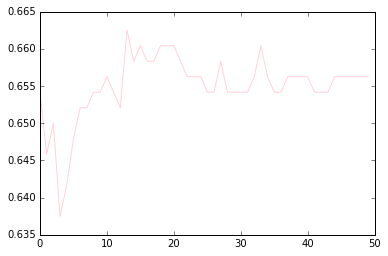

In [157]:
plt.plot(a, 'pink',alpha=0.7)

После 2000 девевьев, точность начинает снижаться и потом идет на одном уровне. Возможно происходит переобучение и на каком-то количестве, например, 3000 деревьев, алгоритм уже практически запоминает тренировочную выборку и, поэтому при дальнейшм увеличении количества деревьев "запоминание" уже не добавляет точности для предсказания на тесте, так как обобщающая способность уже не улучшается.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [7]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/Air11/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


11493376/11490434 [==============================] - 18s 2us/step 


Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
x_test.shape

(10000, 28, 28)

In [10]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [188]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [11]:
x_train = x_train / 255
x_test = x_test / 255

In [195]:
x_train[:2]

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [288]:
from keras.models import Sequential
from keras.layers import Flatten,Dense, Dropout

#Использовала материалы семинара по майнору ИАД (название "Keras")
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [211]:
model.fit(x_train, y_train, epochs=10)
#batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)


Epoch 1/10
60000/60000 [==============================] - 11s - loss: 0.2437 - acc: 0.9286    
Epoch 2/10
60000/60000 [==============================] - 10s - loss: 0.1056 - acc: 0.9681    
Epoch 3/10
60000/60000 [==============================] - 12s - loss: 0.0753 - acc: 0.9762    
Epoch 4/10
60000/60000 [==============================] - 11s - loss: 0.0579 - acc: 0.9819    
Epoch 5/10
60000/60000 [==============================] - 11s - loss: 0.0446 - acc: 0.9858    
Epoch 6/10
60000/60000 [==============================] - 11s - loss: 0.0390 - acc: 0.9869    
Epoch 7/10
60000/60000 [==============================] - 11s - loss: 0.0309 - acc: 0.9897    
Epoch 8/10
60000/60000 [==============================] - 11s - loss: 0.0253 - acc: 0.9917    
Epoch 9/10
60000/60000 [==============================] - 11s - loss: 0.0247 - acc: 0.9917    
Epoch 10/10
60000/60000 [==============================] - 12s - loss: 0.0211 - acc: 0.9926    


Максимальная точность на трейне: 0.9926

In [212]:
print('На тестовой выборке точность:', model.evaluate(x_test, y_test)[1])

 9856/10000 [============================>.] - ETA: 0sНа тестовой выборке точность: 0.9743


На тестовой: 0.9743

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [26]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

In [24]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils


model1 = Sequential()
model1.add(Conv2D(128,(6,6),activation='relu',input_shape=(28, 28, 1)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64,(4,4),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten(input_shape=(28, 28, 1)))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(10, activation='softmax'))


model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model1.fit(x_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0383 - acc: 0.9883
Epoch 2/10
60000/60000 [==============================] - 157s 3ms/step - loss: 0.0283 - acc: 0.9911
Epoch 3/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0220 - acc: 0.9930
Epoch 4/10
60000/60000 [==============================] - 155s 3ms/step - loss: 0.0164 - acc: 0.9946
Epoch 5/10
60000/60000 [==============================] - 162s 3ms/step - loss: 0.0131 - acc: 0.9957
Epoch 6/10
60000/60000 [==============================] - 413s 7ms/step - loss: 0.0116 - acc: 0.9966
Epoch 7/10
60000/60000 [==============================] - 320s 5ms/step - loss: 0.0105 - acc: 0.9968
Epoch 8/10
60000/60000 [==============================] - 199s 3ms/step - loss: 0.0083 - acc: 0.9975
Epoch 9/10
60000/60000 [==============================] - 227s 4ms/step - loss: 0.0075 - acc: 0.9977
Epoch 10/10
60000/60000 [==============================] - 219s 4ms/step - loss: 0.0081 - a

In [29]:
print('На тестовой выборке точность:', model1.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 8s 798us/step
На тестовой выборке точность: 0.9929


Ну точность достигнута, все круто.. 

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

Ну дропаут позволяет избежать переобучения ( мы выключаем часть нейронов при обучении сети). На тесте точность может возрасти.

In [30]:
model2 = Sequential()


model2.add(Conv2D(128,(6,6),activation='relu',input_shape=(28, 28, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.1))

model2.add(Conv2D(64,(4,4),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.1))

model2.add(Flatten(input_shape=(28, 28, 1)))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(10, activation='softmax'))


model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model2.fit(x_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 215s 4ms/step - loss: 0.1207 - acc: 0.9627
Epoch 2/10
60000/60000 [==============================] - 252s 4ms/step - loss: 0.0430 - acc: 0.9869
Epoch 3/10
60000/60000 [==============================] - 222s 4ms/step - loss: 0.0324 - acc: 0.9898
Epoch 4/10
60000/60000 [==============================] - 172s 3ms/step - loss: 0.0236 - acc: 0.9925
Epoch 5/10
60000/60000 [==============================] - 165s 3ms/step - loss: 0.0210 - acc: 0.9931
Epoch 6/10
60000/60000 [==============================] - 161s 3ms/step - loss: 0.0169 - acc: 0.9944
Epoch 7/10
60000/60000 [==============================] - 161s 3ms/step - loss: 0.0145 - acc: 0.9954
Epoch 8/10
60000/60000 [==============================] - 160s 3ms/step - loss: 0.0131 - acc: 0.9956
Epoch 9/10
60000/60000 [==============================] - 163s 3ms/step - loss: 0.0125 - acc: 0.9960
Epoch 10/10
60000/60000 [==============================] - 311s 5ms/step - loss: 0.0098 - a

In [32]:
print('На тестовой выборке точность:', model2.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 26s 3ms/step
На тестовой выборке точность: 0.9896


Стала меньше, странно. Попробуем с одним, но большим дропаутом.

In [34]:
model22 = Sequential()


model22.add(Conv2D(128,(6,6),activation='relu',input_shape=(28, 28, 1)))
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.3))

model22.add(Conv2D(64,(4,4),activation='relu'))
model22.add(MaxPooling2D(pool_size=(2, 2)))
#model22.add(Dropout(0.1))

model22.add(Flatten(input_shape=(28, 28, 1)))
model22.add(Dense(100, activation='relu'))
model22.add(Dense(10, activation='softmax'))


model22.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
model22.fit(x_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 417s 7ms/step - loss: 0.1291 - acc: 0.9593
Epoch 2/10
60000/60000 [==============================] - 417s 7ms/step - loss: 0.0429 - acc: 0.9871
Epoch 3/10
60000/60000 [==============================] - 417s 7ms/step - loss: 0.0323 - acc: 0.9900
Epoch 4/10
60000/60000 [==============================] - 417s 7ms/step - loss: 0.0268 - acc: 0.9917
Epoch 5/10
60000/60000 [==============================] - 437s 7ms/step - loss: 0.0204 - acc: 0.9937
Epoch 6/10
60000/60000 [==============================] - 423s 7ms/step - loss: 0.0180 - acc: 0.9944
Epoch 7/10
60000/60000 [==============================] - 419s 7ms/step - loss: 0.0146 - acc: 0.9954
Epoch 8/10
60000/60000 [==============================] - 430s 7ms/step - loss: 0.0143 - acc: 0.9952
Epoch 9/10
60000/60000 [==============================] - 423s 7ms/step - loss: 0.0122 - acc: 0.9959
Epoch 10/10
60000/60000 [==============================] - 413s 7ms/step - loss: 0.0126 - a

In [37]:
print('На тестовой выборке точность:', model22.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 25s 3ms/step
На тестовой выборке точность: 0.9899


модель не переобучается без дропаутп